In [1]:
from importlib import reload

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.decomposition import PCA

import torch
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import viennarna_shifts as vshifts

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

/homefs/home/wongfanc/miniconda3/envs/viennaenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


2023-11-10 01:15:10.526269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 01:15:10.699866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-10 01:15:10.699898: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-10 01:15:12.661206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1]
After loading k = 0:
223.60679774997897 20.678397512796113 20.572721868309035 223.60679774997897 18.357120551186593 18.153383432506665
0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0
After loading k = 1:
223.60679774997897 20.678397512796113 20.572721868309035 223.60679774997897 18.357120551186593 18.153383432506665
223.60679774997897 19.67350650916428 19.498260616096573 223.60679774997897 18.357120551186593 18.153383432506665
0.0 0.0
After loading training data:
223.60679774997897 20.678397512796113 20.572721868309035 223.60679774997897 18.357120551186593 18.153383432506665
223.60679774997897 19.67350650916428 19.498260616096573 223.60679774997897 18.357120551186593 18.153383432506665
223.60679774997897 18.35848756913648


In [3]:
for name, _ in flexs.landscapes.rna.registry().items():
    print(name)

L14_RNA1
L50_RNA1
L100_RNA1
L14_RNA2
L50_RNA2
L100_RNA2
L14_RNA3
L50_RNA3
L100_RNA3
L14_RNA4
L50_RNA4
L100_RNA4
L14_RNA1+2
L50_RNA1+2
L100_RNA1+2
L14_RNA1+3
L50_RNA1+3
L100_RNA1+3
L14_RNA1+4
L50_RNA1+4
L100_RNA1+4
L14_RNA2+3
L50_RNA2+3
L100_RNA2+3
L14_RNA2+4
L50_RNA2+4
L100_RNA2+4
L14_RNA3+4
L50_RNA3+4
L100_RNA3+4
C20_L100_RNA1+2
C20_L100_RNA1+3
C20_L100_RNA1+4
C20_L100_RNA2+3
C20_L100_RNA2+4
C20_L100_RNA3+4


In [4]:
# problem = flexs.landscapes.tf_binding.registry()['VENTX_E101K_R1']
problem = flexs.landscapes.rna.registry()['L14_RNA1']
pprint.pprint(problem)

seed = problem['starts'][1]

landscape = flexs.landscapes.RNABinding(**problem['params'])
alphabet = s_utils.RNAA

landscape.get_fitness([seed])


{'params': {'seq_length': 14,
            'targets': ['GAACGAGGCACAUUCCGGCUCGCCCGGCCCAUGUGAGCAUGGGCCGGACCCCGUCCGCGCGGGGCCCCCGCGCGGACGGGGGCGAGCCGGAAUGUGCCUC']},
 'starts': {1: 'AUGGGCCGGACCCC',
            2: 'GCCCCGCCGGAAUG',
            3: 'UCUUGGGGACUUUU',
            4: 'GGAUAACAAUUCAU',
            5: 'CCCAUGCGCGAUCA'}}


array([0.54374688])

In [5]:
noisy_models = [
    flexs.baselines.models.NoisyAbstractModel(landscape, signal_strength=ss)
    for ss in [1, 0.9, 0.75, 0]
]

In [6]:
train_x = np.array(list(set(s_utils.generate_random_mutant(seed, 0.2*(i%5), alphabet) for i in range(0, 10000))))
train_y = landscape.get_fitness(train_x)
print (f'training data consists of {len(train_x)} unique sequences')

test_x = np.array(list(set(s_utils.generate_random_mutant(seed, 0.2*(i%5), alphabet=alphabet)
                  for i in range(2000))))
test_y = landscape.get_fitness(test_x)

training data consists of 6843 unique sequences


In [7]:
for model in noisy_models:
    model.train(train_x, train_y)

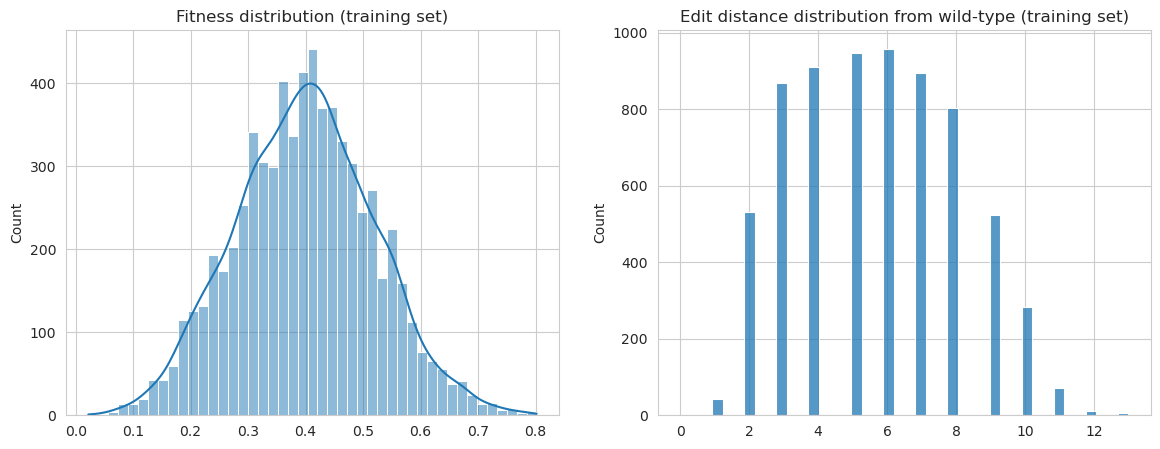

In [8]:
distances = [editdistance.eval(seq, seed) for seq in train_x]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title('Fitness distribution (training set)')
sns.histplot(train_y, kde=True, ax=ax[0])
ax[1].set_title('Edit distance distribution from wild-type (training set)')
sns.histplot(distances, kde=False, ax=ax[1])
plt.show()

In [9]:
def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, seed) for seq in seqs])
    
    for dist in range(1, 9):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 10:
            corrs.append(
                sc.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0]**2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

In [10]:
corrs_noisy_neighbors = [get_corr_per_distance(test_x, test_y, noisy_model.get_fitness(test_x))
                         for noisy_model in noisy_models]

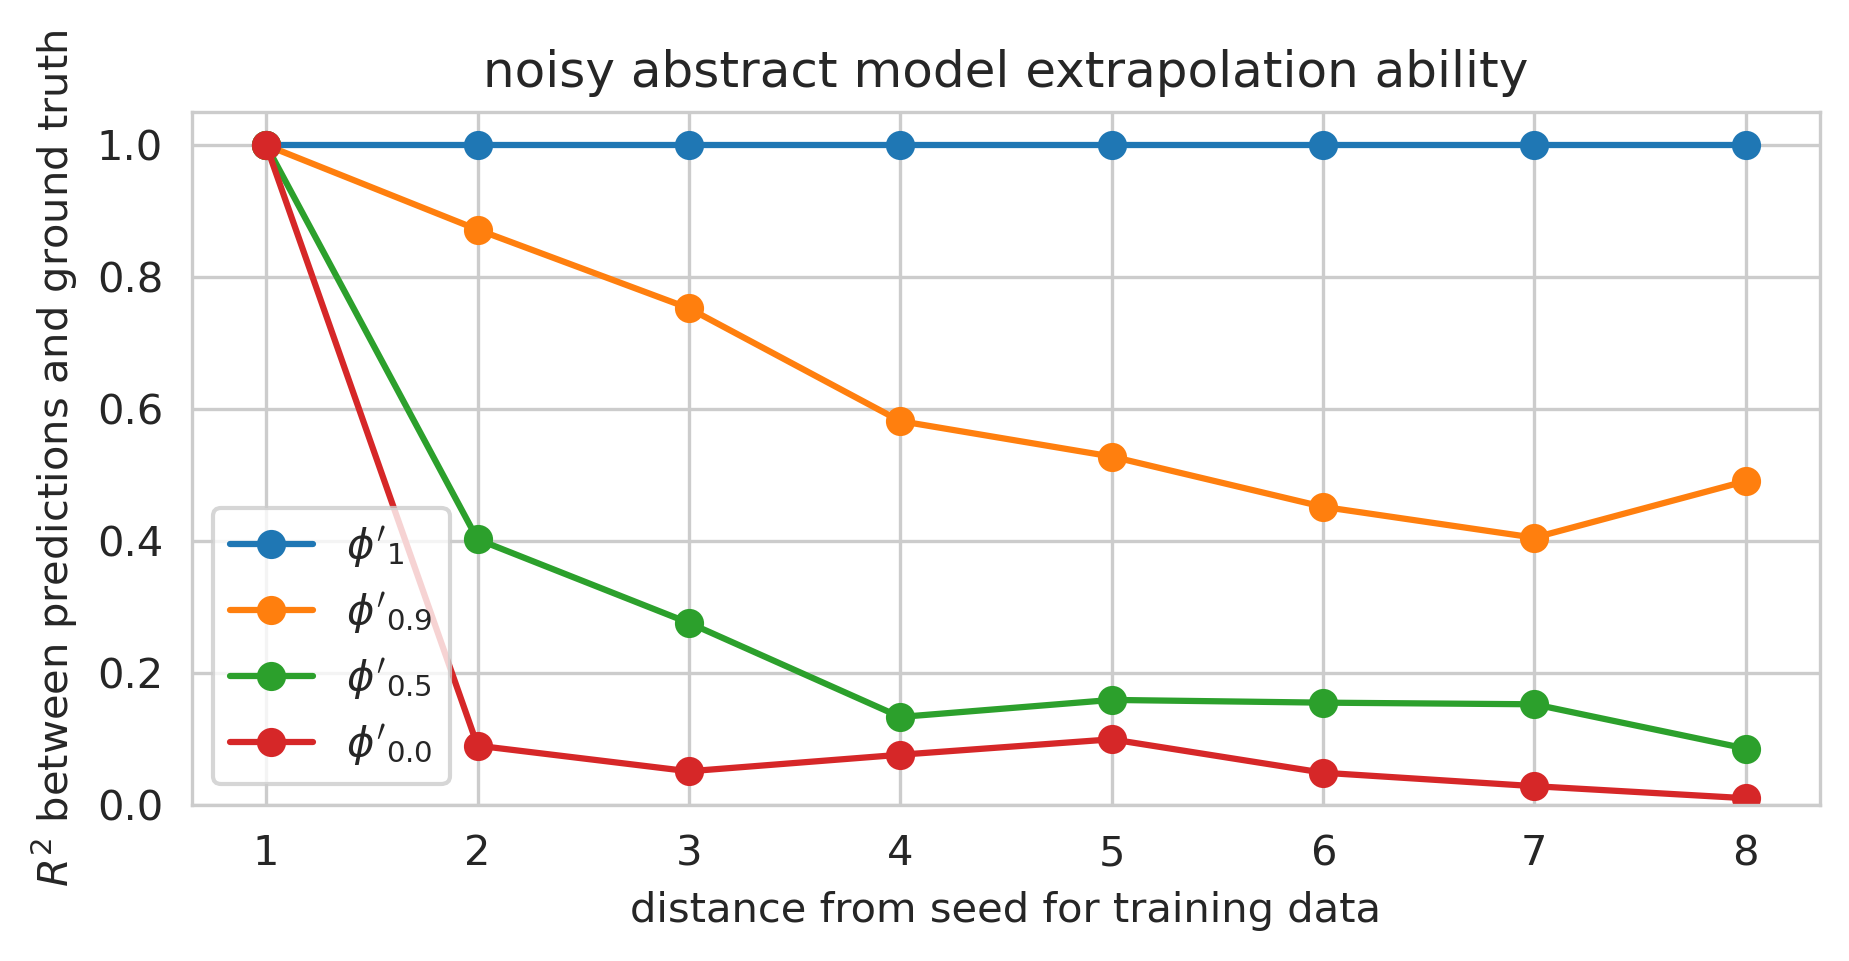

In [11]:
eds = range(1,9)
plt.figure(figsize=(7, 3), dpi=300)
plt.title('noisy abstract model extrapolation ability')
plt.plot(eds, corrs_noisy_neighbors[0], 'o-', label="$\phi'_{1}$")
plt.plot(eds, corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.plot(eds, corrs_noisy_neighbors[2], 'o-', label="$\phi'_{0.5}$")
plt.plot(eds, corrs_noisy_neighbors[3], 'o-', label="$\phi'_{0.0}$")
plt.ylabel("$R^2$ between predictions and ground truth")
plt.xlabel("distance from seed for training data")
plt.legend()
plt.xticks(eds)
plt.ylim([0, 1.05]);
plt.show()


In [12]:
linear_regression = flexs.baselines.models.LinearRegression(alphabet=alphabet)
linear_regression.train(train_x, train_y)

linear_regression_preds = linear_regression.get_fitness(test_x)
corrs_linear = get_corr_per_distance(test_x, test_y, linear_regression_preds)

print(f"Overall correlation: {sc.stats.pearsonr(linear_regression_preds, test_y)[0]**2}")

Overall correlation: 0.7975609477539477


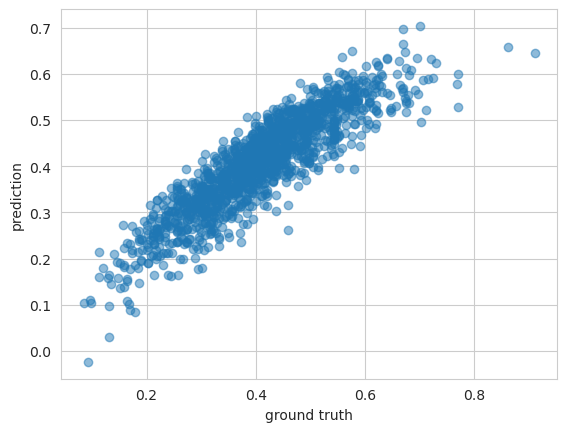

In [13]:
plt.scatter(test_y, linear_regression_preds, alpha=0.5);
plt.xlabel('ground truth');
plt.ylabel('prediction');


In [21]:
reload(flexs)
reload(utils)

n_trial = 100
mu = 1
n_pairs = 1000
n_train = 1000

data_for_df = []

for _ in range(n_trial):

    linear_regression = flexs.baselines.models.LinearRegression(alphabet=alphabet)

    adalead_explorer = flexs.baselines.explorers.Adalead(
        linear_regression,
        mu=mu,
        rounds=2,
        starting_sequence=seed,
        sequences_batch_size=n_train,
        model_queries_per_batch=10000,
        alphabet=alphabet
    )

    adalead_sequences, metadata = adalead_explorer.run(landscape)
    
    seq1_n = adalead_sequences[adalead_sequences['round'] == 1].sequence
    seq2_n = adalead_sequences[adalead_sequences['round'] == 2].sequence
    results = utils.pairwise_distances(seq1_n, seq2_n, n_pairs=n_pairs)
    results = [np.mean(result) for result in results]
    print(results)
    data_for_df.append(results)
df = pd.DataFrame(data_for_df, columns=['within_round1', 'within_round2', 'between_rounds'])

Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000268s
round: 1, top: 0.7304882670751143, time: 0.902949s
round: 2, top: 0.8980062612072313, time: 1.476279s
Normalizing by sequence length 14
[0.6287142857142858, 0.38121428571428567, 0.6549285714285714]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000176s
round: 1, top: 0.7222496462872485, time: 0.938134s
round: 2, top: 0.9556763448245889, time: 1.534564s
Normalizing by sequence length 14
[0.6348571428571428, 0.3639285714285714, 0.6635]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000157s
round: 1, top: 0.6453561665444114, time: 0.895233s
round: 2, top: 0.887021433490077, time: 1.323652s
Normalizing by sequence length 14
[0.6307857142857142, 0.4347142857142857, 0.6625714285714285]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, t

round: 1, top: 0.757950231608919, time: 0.944609s
round: 2, top: 0.9748997409500684, time: 1.590420s
Normalizing by sequence length 14
[0.6345714285714286, 0.3704285714285714, 0.6690714285714287]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000169s
round: 1, top: 0.7222496462872485, time: 0.949560s
round: 2, top: 0.9666611725417431, time: 1.543426s
Normalizing by sequence length 14
[0.6342142857142857, 0.36107142857142854, 0.6609285714285714]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000168s
round: 1, top: 0.6700719241489276, time: 0.890468s
round: 2, top: 0.8815290196314998, time: 1.390978s
Normalizing by sequence length 14
[0.6315714285714285, 0.39057142857142857, 0.6782142857142858]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000169s
round: 1, top: 0.7195034917375004, time: 1.016716s
round: 2, top: 0.9501839309660

round: 2, top: 0.9529301902748407, time: 1.596066s
Normalizing by sequence length 14
[0.6339285714285713, 0.3217857142857143, 0.6793571428571429]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000172s
round: 1, top: 0.7332344740044028, time: 0.934775s
round: 2, top: 0.9199758118824588, time: 1.463155s
Normalizing by sequence length 14
[0.628, 0.35592857142857137, 0.656]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000171s
round: 1, top: 0.7909045576217604, time: 0.978359s
round: 2, top: 0.8842752789403289, time: 1.558067s
Normalizing by sequence length 14
[0.6367857142857142, 0.3266428571428571, 0.6896428571428571]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000173s
round: 1, top: 0.8430823321396218, time: 0.934712s
round: 2, top: 0.999615550934125, time: 1.554528s
Normalizing by sequence length 14
[0.6330714285714285, 0.

round: 1, top: 0.7085186640203461, time: 0.924201s
round: 2, top: 0.8650518828148493, time: 1.426076s
Normalizing by sequence length 14
[0.6304999999999998, 0.4368571428571429, 0.6702857142857143]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000170s
round: 1, top: 0.7469654562713052, time: 0.948975s
round: 2, top: 0.9391992080079383, time: 1.471815s
Normalizing by sequence length 14
[0.6272142857142856, 0.38978571428571424, 0.6468571428571429]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000153s
round: 1, top: 0.68380290641583, time: 0.888428s
round: 2, top: 0.9034986750658084, time: 1.315553s
Normalizing by sequence length 14
[0.6402857142857142, 0.4471428571428571, 0.6733571428571429]
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.5437468768175177, time: 0.000165s
round: 1, top: 0.5986708058851272, time: 0.931439s
round: 2, top: 0.854067107477235

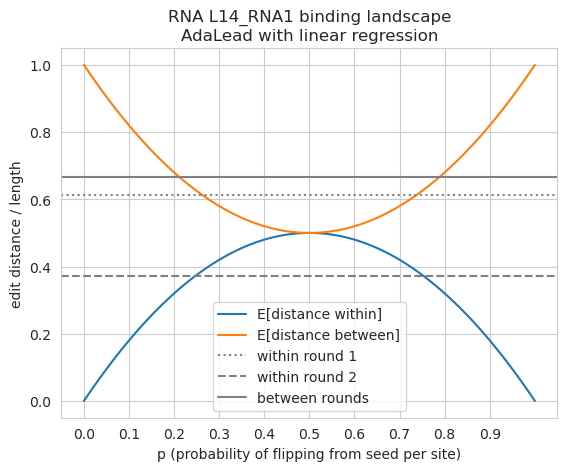

In [19]:
custom_hlines = [
    [np.mean(df['within_round1']), 'within round 1', ':'],
    [np.mean(df['within_round2']), 'within round 2', '--'],
    [np.mean(df['between_rounds']), 'between rounds', '-']
]

ps = np.arange(0, 1.01, 0.01)
y1s = 2 * ps * (1 - ps)
y2s = ps ** 2 + (1 - ps) ** 2
plt.plot(ps, y1s, label='E[distance within]')
plt.plot(ps, y2s, label='E[distance between]')
for thing in custom_hlines:
    plt.axhline(thing[0], color='gray', linestyle=thing[2], label=thing[1])
plt.legend();
plt.xticks(np.arange(0, 1, 0.1))
plt.xlabel('p (probability of flipping from seed per site)');
plt.ylabel('edit distance / length');
plt.title('RNA L14_RNA1 binding landscape\nAdaLead with linear regression');

# classifiers for DRE

Generate and save distributions

In [8]:
mu = 1
threshold = 0.5
n_train = 10000  # explorers may propose fewer than this
landscape_name = 'L50_RNA1'
n_trial_per_seed = 1

# get landscape
problem = flexs.landscapes.rna.registry()[landscape_name]
landscape = flexs.landscapes.RNABinding(**problem['params'])
alphabet = s_utils.RNAA
linear_regression = flexs.baselines.models.LinearRegression(alphabet=alphabet)

for s, seed in problem['starts'].items():
    for t in range(n_trial_per_seed):
    
        adalead_explorer = flexs.baselines.explorers.Adalead(
            linear_regression,
            mu=mu,
            rounds=2,
            starting_sequence=seed,
            sequences_batch_size=n_train,
            model_queries_per_batch=10000,  # doesn't matter
            alphabet=alphabet,
            threshold=threshold
        )
        adalead_sequences, metadata = adalead_explorer.run(landscape)
        adalead_sequences.to_csv('flexs/110323/{}_seed{}_trial{}_thresh{}.csv'.format(
            landscape_name, s, t, threshold
        ))

Round 0 reports the seed only, not all the training data.
round: 0, top: 0.6443675592872286, time: 0.000276s
round: 1, top: 0.6574394309392855, time: 57.474372s
round: 2, top: 0.6612841059740182, time: 47.456993s
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.9027297098882465, time: 0.000228s
round: 1, top: 0.9088811547447676, time: 57.651018s
round: 2, top: 0.9088811547447676, time: 40.345033s
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.31526335284807844, time: 0.000274s
round: 1, top: 0.5059592580368527, time: 57.383341s
round: 2, top: 0.5105728563455149, time: 51.871568s
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.28911955087887925, time: 0.000225s
round: 1, top: 0.4659746024765818, time: 57.546641s
round: 2, top: 0.5182622064149801, time: 52.116806s
Round 0 reports the seed only, not all the training data.
round: 0, top: 0.18685120082149892, time: 0.000197s
round: 1, top: 0.5059592580368527, t

Normalizing by sequence length 14
0.6433571428571427


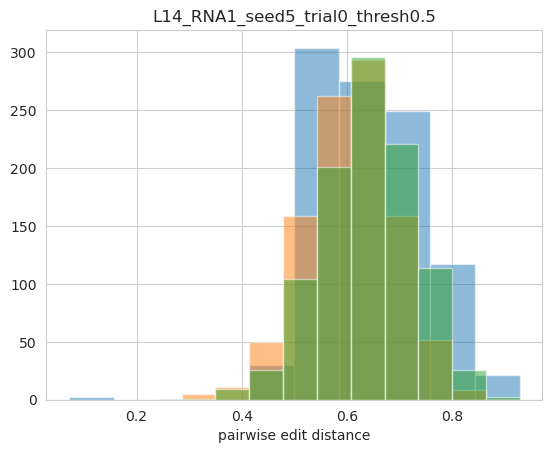

In [21]:
landscape_name = 'L14_RNA1'
s = 5
t = 0 # only 0
threshold = 0.5

df = pd.read_csv('flexs/110323/{}_seed{}_trial{}_thresh{}.csv'.format(landscape_name, s, t, threshold))
df1 = df[df['round'] == 1]
df2 = df[df['round'] == 2]

dists_within1, dists_within2, dists_between = utils.pairwise_distances(
    df1.sequence.values.tolist(), df2.sequence.values.tolist())

plt.hist(dists_within1, alpha=0.5);
plt.hist(dists_within2, alpha=0.5);
plt.hist(dists_between, alpha=0.5);
print(np.mean(dists_between))
plt.xlabel('pairwise edit distance');
plt.title('{}_seed{}_trial{}_thresh{}'.format(landscape_name, s, t, threshold));

In [8]:
reload(tdre)
ms = np.array([1, 3, 5, 7, 10])
landscape_name = 'L14_RNA1'
n_trial_per_seed = 2

n_train = 5000
d = 14 * 4
n_hidden = 64
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-4,
}

# get landscape
problem = flexs.landscapes.rna.registry()[landscape_name]
alphabet = s_utils.RNAA
results_sxtxmx3 = np.zeros([len(problem['starts']), n_trial_per_seed, len(ms), 3])

for s, seed in problem['starts'].items():
    for t in range(n_trial_per_seed):
        
        df = pd.read_csv('flexs/103123/{}_seed{}_trial{}.csv'.format(landscape_name, s, t, index_col=0))
        outputs = utils.process_flexs_outputs(df, alphabet, n_train)
        X0_nxd, y0_n, pred0_n, Xm_nxd, Xmcal_nxd, ymcal_n = outputs
        meantrue = np.mean(y0_n)
        meannaive = np.mean(pred0_n)
        
        for mi, m in enumerate(ms):
            model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
                lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
                device=device, dtype=dtype
            )
            train_dfs = model.fit(X0_nxd, Xm_nxd, config)
            forecast = model.forecast_meany(Xmcal_nxd, ymcal_n, use_logsumexp=True)
            
            results_sxtxmx3[s, t, mi] = meantrue, forecast, meannaive
            print('True: {:.3f}, forecast: {:.3f}, naive: {:.3f}'.format(meantrue, forecast, meannaive))

Generated 1 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 599.80it/s]


Done fitting bridge 1 / 1 (8 s).
True: 0.545, forecast: 0.657, naive: 0.492
Waymark 1 / 2 has 18, 38 dimensions from P0, Pm.
Waymark 2 / 2 has 36, 20 dimensions from P0, Pm.
Generated 3 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 581.47it/s]


Done fitting bridge 1 / 3 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 598.50it/s]


Done fitting bridge 2 / 3 (16 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 599.29it/s]


Done fitting bridge 3 / 3 (25 s).
True: 0.545, forecast: 0.684, naive: 0.492
Waymark 1 / 4 has 11, 45 dimensions from P0, Pm.
Waymark 2 / 4 has 22, 34 dimensions from P0, Pm.
Waymark 3 / 4 has 33, 23 dimensions from P0, Pm.
Waymark 4 / 4 has 44, 12 dimensions from P0, Pm.
Generated 5 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 599.65it/s]


Done fitting bridge 1 / 5 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.28it/s]


Done fitting bridge 2 / 5 (16 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.08it/s]


Done fitting bridge 3 / 5 (25 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.26it/s]


Done fitting bridge 4 / 5 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 600.23it/s]


Done fitting bridge 5 / 5 (41 s).
True: 0.545, forecast: 0.291, naive: 0.492
Waymark 1 / 6 has 8, 48 dimensions from P0, Pm.
Waymark 2 / 6 has 16, 40 dimensions from P0, Pm.
Waymark 3 / 6 has 24, 32 dimensions from P0, Pm.
Waymark 4 / 6 has 32, 24 dimensions from P0, Pm.
Waymark 5 / 6 has 40, 16 dimensions from P0, Pm.
Waymark 6 / 6 has 48, 8 dimensions from P0, Pm.
Generated 7 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.07it/s]


Done fitting bridge 1 / 7 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 593.79it/s]


Done fitting bridge 2 / 7 (16 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.22it/s]


Done fitting bridge 3 / 7 (25 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.40it/s]


Done fitting bridge 4 / 7 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 594.52it/s]


Done fitting bridge 5 / 7 (42 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 598.85it/s]


Done fitting bridge 6 / 7 (50 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 599.18it/s]


Done fitting bridge 7 / 7 (58 s).
True: 0.545, forecast: 0.083, naive: 0.492
Waymark 1 / 9 has 5, 51 dimensions from P0, Pm.
Waymark 2 / 9 has 10, 46 dimensions from P0, Pm.
Waymark 3 / 9 has 15, 41 dimensions from P0, Pm.
Waymark 4 / 9 has 20, 36 dimensions from P0, Pm.
Waymark 5 / 9 has 25, 31 dimensions from P0, Pm.
Waymark 6 / 9 has 30, 26 dimensions from P0, Pm.
Waymark 7 / 9 has 35, 21 dimensions from P0, Pm.
Waymark 8 / 9 has 40, 16 dimensions from P0, Pm.
Waymark 9 / 9 has 45, 11 dimensions from P0, Pm.
Generated 10 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.93it/s]


Done fitting bridge 1 / 10 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 594.03it/s]


Done fitting bridge 2 / 10 (16 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 594.04it/s]


Done fitting bridge 3 / 10 (25 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 594.44it/s]


Done fitting bridge 4 / 10 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 597.28it/s]


Done fitting bridge 5 / 10 (42 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 593.83it/s]


Done fitting bridge 6 / 10 (50 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 572.53it/s]


Done fitting bridge 7 / 10 (59 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.99it/s]


Done fitting bridge 8 / 10 (67 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 593.59it/s]


Done fitting bridge 9 / 10 (76 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 597.26it/s]


Done fitting bridge 10 / 10 (84 s).
True: 0.545, forecast: 0.157, naive: 0.492
Generated 1 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.64it/s]


Done fitting bridge 1 / 1 (8 s).
True: 0.598, forecast: 0.492, naive: 0.515
Waymark 1 / 2 has 18, 38 dimensions from P0, Pm.
Waymark 2 / 2 has 36, 20 dimensions from P0, Pm.
Generated 3 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.00it/s]


Done fitting bridge 1 / 3 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 573.04it/s]


Done fitting bridge 2 / 3 (17 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 579.16it/s]


Done fitting bridge 3 / 3 (25 s).
True: 0.598, forecast: 0.395, naive: 0.515
Waymark 1 / 4 has 11, 45 dimensions from P0, Pm.
Waymark 2 / 4 has 22, 34 dimensions from P0, Pm.
Waymark 3 / 4 has 33, 23 dimensions from P0, Pm.
Waymark 4 / 4 has 44, 12 dimensions from P0, Pm.
Generated 5 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 598.71it/s]


Done fitting bridge 1 / 5 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.33it/s]


Done fitting bridge 2 / 5 (16 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 597.70it/s]


Done fitting bridge 3 / 5 (25 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 597.78it/s]


Done fitting bridge 4 / 5 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 599.74it/s]


Done fitting bridge 5 / 5 (41 s).
True: 0.598, forecast: 0.152, naive: 0.515
Waymark 1 / 6 has 8, 48 dimensions from P0, Pm.
Waymark 2 / 6 has 16, 40 dimensions from P0, Pm.
Waymark 3 / 6 has 24, 32 dimensions from P0, Pm.
Waymark 4 / 6 has 32, 24 dimensions from P0, Pm.
Waymark 5 / 6 has 40, 16 dimensions from P0, Pm.
Waymark 6 / 6 has 48, 8 dimensions from P0, Pm.
Generated 7 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 600.37it/s]


Done fitting bridge 1 / 7 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 594.57it/s]


Done fitting bridge 2 / 7 (16 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 580.80it/s]


Done fitting bridge 3 / 7 (25 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 577.73it/s]


Done fitting bridge 4 / 7 (34 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 601.84it/s]


Done fitting bridge 5 / 7 (42 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 582.82it/s]


Done fitting bridge 6 / 7 (50 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 581.00it/s]


Done fitting bridge 7 / 7 (59 s).
True: 0.598, forecast: 0.254, naive: 0.515
Waymark 1 / 9 has 5, 51 dimensions from P0, Pm.
Waymark 2 / 9 has 10, 46 dimensions from P0, Pm.
Waymark 3 / 9 has 15, 41 dimensions from P0, Pm.
Waymark 4 / 9 has 20, 36 dimensions from P0, Pm.
Waymark 5 / 9 has 25, 31 dimensions from P0, Pm.
Waymark 6 / 9 has 30, 26 dimensions from P0, Pm.
Waymark 7 / 9 has 35, 21 dimensions from P0, Pm.
Waymark 8 / 9 has 40, 16 dimensions from P0, Pm.
Waymark 9 / 9 has 45, 11 dimensions from P0, Pm.
Generated 10 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 575.98it/s]


Done fitting bridge 1 / 10 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 594.43it/s]


Done fitting bridge 2 / 10 (17 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 598.25it/s]


Done fitting bridge 3 / 10 (25 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.41it/s]


Done fitting bridge 4 / 10 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 592.88it/s]


Done fitting bridge 5 / 10 (42 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.93it/s]


Done fitting bridge 6 / 10 (50 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 577.33it/s]


Done fitting bridge 7 / 10 (59 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 598.69it/s]


Done fitting bridge 8 / 10 (67 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.47it/s]


Done fitting bridge 9 / 10 (76 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 600.94it/s]


Done fitting bridge 10 / 10 (84 s).
True: 0.598, forecast: 0.113, naive: 0.515
Generated 1 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.62it/s]


Done fitting bridge 1 / 1 (8 s).
True: 0.592, forecast: 0.539, naive: 0.544
Waymark 1 / 2 has 18, 38 dimensions from P0, Pm.
Waymark 2 / 2 has 36, 20 dimensions from P0, Pm.
Generated 3 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 584.17it/s]


Done fitting bridge 1 / 3 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.83it/s]


Done fitting bridge 2 / 3 (16 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.54it/s]


Done fitting bridge 3 / 3 (25 s).
True: 0.592, forecast: 0.487, naive: 0.544
Waymark 1 / 4 has 11, 45 dimensions from P0, Pm.
Waymark 2 / 4 has 22, 34 dimensions from P0, Pm.
Waymark 3 / 4 has 33, 23 dimensions from P0, Pm.
Waymark 4 / 4 has 44, 12 dimensions from P0, Pm.
Generated 5 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 598.47it/s]


Done fitting bridge 1 / 5 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 572.73it/s]


Done fitting bridge 2 / 5 (17 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 592.41it/s]


Done fitting bridge 3 / 5 (25 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 593.82it/s]


Done fitting bridge 4 / 5 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 601.59it/s]


Done fitting bridge 5 / 5 (42 s).
True: 0.592, forecast: 0.284, naive: 0.544
Waymark 1 / 6 has 8, 48 dimensions from P0, Pm.
Waymark 2 / 6 has 16, 40 dimensions from P0, Pm.
Waymark 3 / 6 has 24, 32 dimensions from P0, Pm.
Waymark 4 / 6 has 32, 24 dimensions from P0, Pm.
Waymark 5 / 6 has 40, 16 dimensions from P0, Pm.
Waymark 6 / 6 has 48, 8 dimensions from P0, Pm.
Generated 7 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 597.11it/s]


Done fitting bridge 1 / 7 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.91it/s]


Done fitting bridge 2 / 7 (16 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 596.61it/s]


Done fitting bridge 3 / 7 (25 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 597.77it/s]


Done fitting bridge 4 / 7 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.16it/s]


Done fitting bridge 5 / 7 (41 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 595.19it/s]


Done fitting bridge 6 / 7 (50 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 598.62it/s]


Done fitting bridge 7 / 7 (58 s).
True: 0.592, forecast: 0.075, naive: 0.544
Waymark 1 / 9 has 5, 51 dimensions from P0, Pm.
Waymark 2 / 9 has 10, 46 dimensions from P0, Pm.
Waymark 3 / 9 has 15, 41 dimensions from P0, Pm.
Waymark 4 / 9 has 20, 36 dimensions from P0, Pm.
Waymark 5 / 9 has 25, 31 dimensions from P0, Pm.
Waymark 6 / 9 has 30, 26 dimensions from P0, Pm.
Waymark 7 / 9 has 35, 21 dimensions from P0, Pm.
Waymark 8 / 9 has 40, 16 dimensions from P0, Pm.
Waymark 9 / 9 has 45, 11 dimensions from P0, Pm.
Generated 10 waymarks.


 56%|███████████████████████████████████████████████████████████████████▋                                                     | 2798/5000 [00:04<00:03, 595.51it/s]

KeyboardInterrupt



In [2]:
d = 14 * 4
m = 14
landscape_name = 'L14_RNA1'
s = 1
t = 0
n_train = 5000
thresh = 0.5

n_hidden = 64
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

# get landscape
problem = flexs.landscapes.rna.registry()[landscape_name]
alphabet = s_utils.RNAA

df = pd.read_csv('flexs/110323/{}_seed{}_trial{}_thresh{}.csv'.format(landscape_name, s, t, thresh), index_col=0)
outputs = utils.process_flexs_outputs(df, alphabet, n_train)
X0_nxd, y0_n, pred0_n, Xm_nxd, Xmcal_nxd, ymcal_n, predmcal_n = outputs
meantrue = np.mean(y0_n)
meannaive = np.mean(pred0_n)

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
    # lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)
train_dfs = model.fit(X0_nxd, Xm_nxd, config)
forecast = model.forecast_meany(Xmcal_nxd, ymcal_n, use_logsumexp=True)
rect = model.forecast_meany(Xmcal_nxd, predmcal_n - ymcal_n, use_logsumexp=True)
pp_forecast = np.mean(pred0_n) - rect


Waymark 1 / 13 has 4, 52 dimensions from P0, Pm.
Waymark 2 / 13 has 8, 48 dimensions from P0, Pm.
Waymark 3 / 13 has 12, 44 dimensions from P0, Pm.
Waymark 4 / 13 has 16, 40 dimensions from P0, Pm.
Waymark 5 / 13 has 20, 36 dimensions from P0, Pm.
Waymark 6 / 13 has 24, 32 dimensions from P0, Pm.
Waymark 7 / 13 has 28, 28 dimensions from P0, Pm.
Waymark 8 / 13 has 32, 24 dimensions from P0, Pm.
Waymark 9 / 13 has 36, 20 dimensions from P0, Pm.
Waymark 10 / 13 has 40, 16 dimensions from P0, Pm.
Waymark 11 / 13 has 44, 12 dimensions from P0, Pm.
Waymark 12 / 13 has 48, 8 dimensions from P0, Pm.
Waymark 13 / 13 has 52, 4 dimensions from P0, Pm.
Generated 14 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 752.10it/s]


Done fitting bridge 1 / 14 (7 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 763.10it/s]


Done fitting bridge 2 / 14 (13 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 764.29it/s]


Done fitting bridge 3 / 14 (20 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 767.45it/s]


Done fitting bridge 4 / 14 (27 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 764.02it/s]


Done fitting bridge 5 / 14 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 787.62it/s]


Done fitting bridge 6 / 14 (39 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 781.44it/s]


Done fitting bridge 7 / 14 (46 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 737.94it/s]


Done fitting bridge 8 / 14 (53 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 777.46it/s]


Done fitting bridge 9 / 14 (59 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 778.06it/s]


Done fitting bridge 10 / 14 (66 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 754.76it/s]


Done fitting bridge 11 / 14 (72 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 775.40it/s]


Done fitting bridge 12 / 14 (79 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 768.52it/s]


Done fitting bridge 13 / 14 (85 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 770.57it/s]

Done fitting bridge 14 / 14 (92 s).


In [7]:
reload(tdre)
reload(utils)
d = 14 * 4
m = 14
landscape_name = 'L14_RNA1'
s = 1
t = 0
n_train = 5000
thresh = 0.5

n_hidden = 32
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

# get landscape
problem = flexs.landscapes.rna.registry()[landscape_name]
alphabet = s_utils.RNAA

df = pd.read_csv('flexs/110323/{}_seed{}_trial{}_thresh{}.csv'.format(landscape_name, s, t, thresh), index_col=0)
outputs = utils.process_flexs_outputs(df, alphabet, n_train)
X0_nxd, y0_n, pred0_n, Xm_nxd, Xmcal_nxd, ymcal_n, predmcal_n = outputs
meantrue = np.mean(y0_n)
meannaive = np.mean(pred0_n)

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
    tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype,
    use_mixeddimclassifier=True,
    n_hidden=n_hidden
)
train_dfs = model.fit(X0_nxd, Xm_nxd, config)
forecast = model.forecast_meany(Xmcal_nxd, ymcal_n, use_logsumexp=True)
rect = model.forecast_meany(Xmcal_nxd, predmcal_n - ymcal_n, use_logsumexp=True)
pp_forecast = np.mean(pred0_n) - rect

n_ratio must be the sequence length! 
Waymark 1 / 13 has 4, 52 dimensions from P0, Pm.
Waymark 2 / 13 has 8, 48 dimensions from P0, Pm.
Waymark 3 / 13 has 12, 44 dimensions from P0, Pm.
Waymark 4 / 13 has 16, 40 dimensions from P0, Pm.
Waymark 5 / 13 has 20, 36 dimensions from P0, Pm.
Waymark 6 / 13 has 24, 32 dimensions from P0, Pm.
Waymark 7 / 13 has 28, 28 dimensions from P0, Pm.
Waymark 8 / 13 has 32, 24 dimensions from P0, Pm.
Waymark 9 / 13 has 36, 20 dimensions from P0, Pm.
Waymark 10 / 13 has 40, 16 dimensions from P0, Pm.
Waymark 11 / 13 has 44, 12 dimensions from P0, Pm.
Waymark 12 / 13 has 48, 8 dimensions from P0, Pm.
Waymark 13 / 13 has 52, 4 dimensions from P0, Pm.
Generated 14 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 567.14it/s]


Done fitting bridge 1 / 14 (8 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 421.79it/s]


Done fitting bridge 2 / 14 (20 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 395.59it/s]


Done fitting bridge 3 / 14 (33 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 394.68it/s]


Done fitting bridge 4 / 14 (46 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 400.97it/s]


Done fitting bridge 5 / 14 (58 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 400.50it/s]


Done fitting bridge 6 / 14 (70 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 383.21it/s]


Done fitting bridge 7 / 14 (84 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 379.11it/s]


Done fitting bridge 8 / 14 (97 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 387.53it/s]


Done fitting bridge 9 / 14 (110 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 397.53it/s]


Done fitting bridge 10 / 14 (122 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 426.25it/s]


Done fitting bridge 11 / 14 (134 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 420.00it/s]


Done fitting bridge 12 / 14 (146 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 390.17it/s]


Done fitting bridge 13 / 14 (159 s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 571.03it/s]


Done fitting bridge 14 / 14 (168 s).


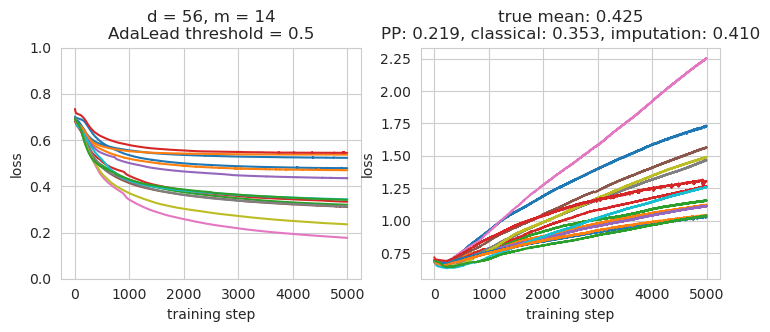

In [11]:
m = len(train_dfs)
m_to_plot = 14

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('d = {}, m = {}\nAdaLead threshold = {}'.format(d, m, thresh));
plt.ylim([0, 1]);
plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('true mean: {:.3f}\nPP: {:.3f}, classical: {:.3f}, imputation: {:.3f}'.format(
    np.mean(y0_n), pp_forecast, forecast, np.mean(pred0_n)
));
# plt.ylim([0, 1]);

# isotropic training sequences

In [9]:
thresh = 0.3
d = np.load('mango.npz')
trainseqs_n = d['trainseqs_n']
ytrain_n = d['ytrain_n']
testseqs_m = d['testseqs_m']
ytest_m = d['ytest_m']
predtest_m = d['predtest_m']

In [24]:
d = 14 * 4
m = 1
s = 1
n_hidden = 16
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

Xm_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in trainseqs_n])
X0_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_m])
model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
    lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    # tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)
train_dfs = model.fit(X0_nxd, Xm_nxd, config)
forecast = model.forecast_meany(Xm_nxd, ytrain_n, use_logsumexp=True)
print(np.mean(ytest_m), forecast, np.mean(predtest_m))

Generated 1 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 413.68it/s]

Done fitting bridge 1 / 1 (12 s).
0.5807263554349029 0.5810384667844152 0.5995692626953125


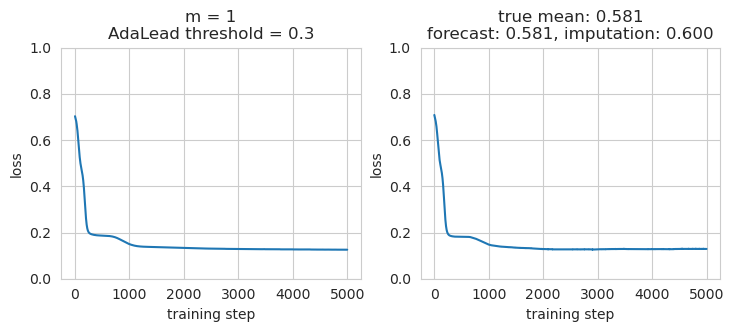

In [25]:
m_to_plot = 1

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('m = {}\nAdaLead threshold = {}'.format(m, thresh));
plt.ylim([0, 1]);
plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('true mean: {:.3f}\nforecast: {:.3f}, imputation: {:.3f}'.format(
    np.mean(ytest_m), forecast, np.mean(predtest_m)
));
plt.ylim([0, 1]);